# Mass Spectrometry to Predict Cancers

This dataset contains standardized mass spectrometry data of 901 samples with three different outcomes
    1. overian cancer (female only)
    2. prostate cancer (male only)
    3. control group

- Data source is from UCI Machine Learning Repo "Arcene Datast" (https://archive.ics.uci.edu/ml/datasets/Arcene)
- The dataset contains 10,000 features and 901 samples


## Import Data and Exploration 


(99, 10000)
(99, 1)
Creating tsne visualizations...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 99 samples in 0.021s...
[t-SNE] Computed neighbors for 99 samples in 0.347s...
[t-SNE] Computed conditional probabilities for sample 99 / 99
[t-SNE] Mean sigma: 1531.163447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.921066
[t-SNE] Error after 2600 iterations: 0.600546
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 99 samples in 0.014s...
[t-SNE] Computed neighbors for 99 samples in 0.180s...
[t-SNE] Computed conditional probabilities for sample 99 / 99
[t-SNE] Mean sigma: 2054.109905
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.077576
[t-SNE] Error after 850 iterations: 0.681978
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 99 samples in 0.029s...
[t-SNE] Computed neighbors for 99 samples in 0.317s...
[t-SNE] Computed conditional probabilities for sample 99 / 99
[t-SNE] Mean sigma: 2511.522546
[t-SNE] 

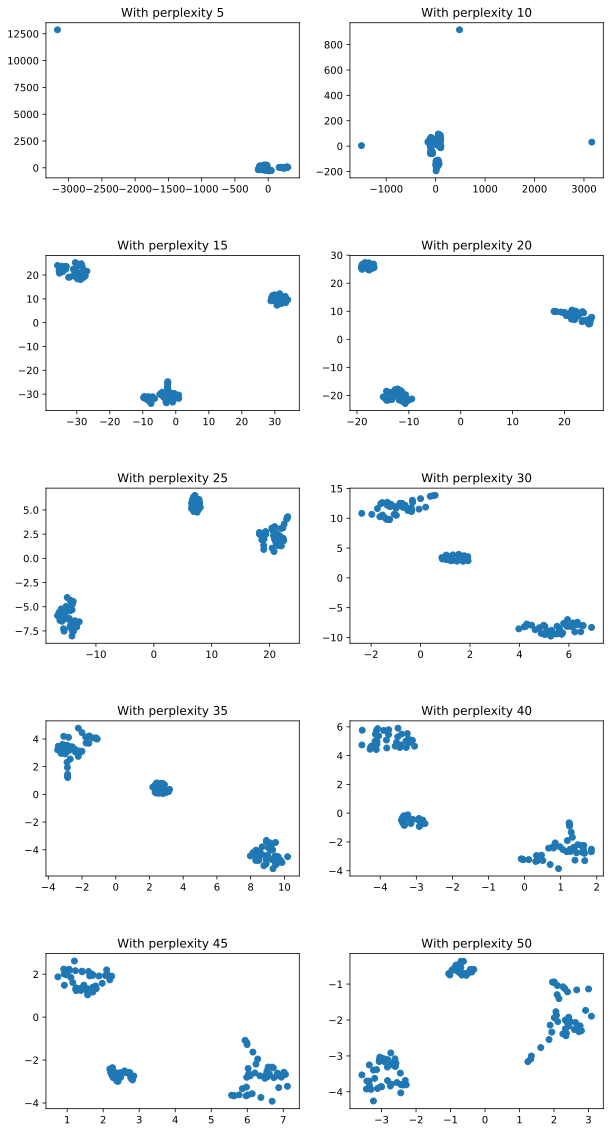

In [26]:
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
%matplotlib inline


def convert_to_csv(input, output):
    with open(input) as fin, open(output, 'w') as fout:
        o = csv.writer(fout)
        for line in fin:
            o.writerow(line.split())


# convert data files to csv format
convert_to_csv("./data/original/train.labels", "./data/train_labels.csv")
convert_to_csv("./data/original/test.data", "./data/test.csv")
convert_to_csv("./data/original/test.data", "./data/test.csv")
convert_to_csv("./data/original/valid.data", "./data/valid.csv")
convert_to_csv("./data/original/valid.labels", "./data/valid_labels.csv")


def make_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)


# make some dictionaries
make_directory("images")
make_directory("models")
make_directory("./data/train")
make_directory("./data/test")

# load the dataset
X = pd.read_csv("data/train.csv")
y = pd.read_csv("data/train_labels.csv")

# basic overview of data dimension
print(X.shape)
print(y.shape)

X_data = X.values
y_data = y.values.flatten()

print("Creating tsne visualizations...")


def tsne_visualization():
    PERLEXITY = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    fig, axes = plt.subplots(5, 2, figsize=(10, 20), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=.5, wspace=.2)
    for i in range(10):
        ax = axes.flatten()[i]
        tsne = TSNE(n_components=2, verbose=1, perplexity=PERLEXITY[i], n_iter=5000, random_state=100)
        tsne_results = tsne.fit_transform(X_data)
        x_axis = tsne_results[:, 0]
        y_axis = tsne_results[:, 1]
        ax.scatter(x_axis, y_axis)
        ax.set_title("With perplexity {}".format(PERLEXITY[i]))


# use TSNE to visualize the high dimension data in 2D
tsne_visualization()

# Shuttle the data and split it into training and test set
X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.20, random_state=100, stratify=y, shuffle=True)

# save the train and test csv files
X_train.to_csv("./data/train/X_train.csv")
y_train.to_csv("./data/train/y_train.csv")
X_test.to_csv("./data/test/X_test.csv")
y_test.to_csv("./data/test/y_test.csv")

Different perplexity values result in different 2D visualization of mass spectrometry data. Lower perplexity causes data points to clump together. As perlexity increases, the datas starts to show three clusters.

## Model Selection and Tuning

In [ ]:
import os
import time
import pandas as pd
import numpy as np
from sklearn import svm, ensemble, linear_model
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib
from sklearn.metrics import recall_score

# load the training data
print("Loading data sets...")
X_train = pd.read_csv("./data/train/X_train.csv")
y_train = pd.read_csv("./data/train/y_train.csv")
X_test = pd.read_csv("./data/test/X_test.csv")
y_test = pd.read_csv("./data/test/y_test.csv")

# transform panda df into arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

index_to_delete = []
for i in range(len(y_train)):
    if i % 2 == 0:
        index_to_delete.append(i)

y_train = np.delete(y_train, index_to_delete)
y_test = np.delete(y_test, index_to_delete)

print(X_train)
print(y_train)

print(X_train.shape)
print(y_train.shape)

print("Dataset loaded.")

# define the models
logit = linear_model.LogisticRegression(random_state=100, dual=False)
linear_svm = svm.LinearSVC(random_state=100, dual=False)
none_linear_svm = svm.SVC(random_state=100)
rf = ensemble.RandomForestClassifier(random_state=100)
nn = MLPClassifier(random_state=100)


#################################################################################
# test the models before parameter tuning
#################################################################################
def model_recall_test(model, model_name):
    t0 = time.time()
    model = model.fit(X_train, y_train)
    t1 = time.time()
    padding = 16
    recall = recall_score(y_true=y_test, y_pred=model.predict(X_test), average="macro")
    print("{}      {:0.4}      {:0.4}".format(model_name.ljust(padding), (t1 - t0), recall))


print("Model         Training time     Recall score")
model_recall_test(logit, "Logistic regression ")
model_recall_test(linear_svm, "Linear svm")
model_recall_test(none_linear_svm, "None-linear svm")
model_recall_test(rf, "Random forest")
model_recall_test(nn, "Neuron network ")

#################################################################################
#  Perform  parameter tuning
#################################################################################
print("Parameter tuning starts...")


def model_tune_params(model, params):
    if __name__ == '__main__':
        new_model = GridSearchCV(estimator=model,
                                 param_grid=params, cv=5, n_jobs=-1,
                                 scoring="recall_macro")
        new_model.fit(X_train, y_train)
        return new_model


logit_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ('l2', 'l1')
}

linear_svm_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ('l2', 'l1')
}

none_linear_svm_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'gamma': [0.001, 0.0001, 0.00001],
    'kernel': ('poly', 'rbf', 'sigmoid')
}
rf_params = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_leaf_nodes': [50, 100, 150, 200],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy']
}

nn_params = {
    'hidden_layer_sizes': [50, 100, 200, 500],
    'alpha': [0.0001, 0.0005, 0.001, 0.005],
    'activation': ('relu', 'tanh', 'identity'),
}

logit = model_tune_params(logit, logit_params)
linear_svm = model_tune_params(linear_svm, linear_svm_params)
none_linear_svm = model_tune_params(none_linear_svm, none_linear_svm_params)
rf = model_tune_params(rf, rf_params)
nn = model_tune_params(nn, nn_params)

# save the models
if not os.path.exists("models"):
    os.makedirs("models")

joblib.dump(logit, "models/logit.pkl", compress=3)
joblib.dump(linear_svm, "models/linear_svm.pkl", compress=3)
joblib.dump(none_linear_svm, "models/none_linear_svm.pkl", compress=3)
joblib.dump(rf, "models/rf.pkl", compress=3)
joblib.dump(nn, "models/nn.pkl", compress=3)
print("Models saved.")

## Model Evaluation

Loading data sets...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


[[ 26   0  38 ...,   0  55 486]
 [ 77  98  56 ...,   0 184 360]
 [  8  38 113 ...,   0  10 179]
 ..., 
 [ 72  29  25 ...,   0 191 227]
 [  5  76  80 ...,   0  17 412]
 [ 52 170   3 ...,   0  58 364]]
[-1 -1 -1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1  1  1
 -1  1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1
 -1  1 -1  1  1 -1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1
  1 -1  1 -1]
(79, 10001)
(79,)
Dataset loaded.
Models loaded


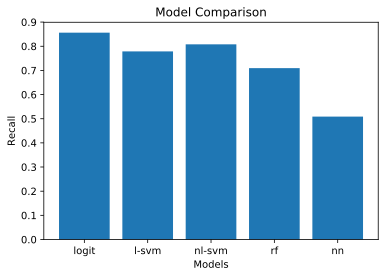

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score

# load the training data
print("Loading data sets...")
X_train = pd.read_csv("data/train/X_train.csv")
y_train = pd.read_csv("data/train/y_train.csv")
X_test = pd.read_csv("data/test/X_test.csv")
y_test = pd.read_csv("data/test/y_test.csv")

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()
index_to_delete = []
for i in range(len(y_train)):
    if i % 2 == 0:
        index_to_delete.append(i)

y_train = np.delete(y_train, index_to_delete)
y_test = np.delete(y_test, index_to_delete)

print(X_train)
print(y_train)

print(X_train.shape)
print(y_train.shape)

print("Dataset loaded.")


def load_model(path):
    return pickle.load(open(path, "rb"))
# load models
logit = load_model("models/logit.pkl")
linear_svm = load_model("models/linear_svm.pkl")
none_linear_svm = load_model("models/none_linear_svm.pkl")
rf = load_model("models/rf.pkl")
nn = load_model("models/nn.pkl")
print("Models loaded")


def get_cv_scores(scoring="recall_macro", cv=5):
    cv_scores = []
    cv_scores.append(cross_val_score(logit, X_train, y_train, scoring=scoring, cv=cv).mean())
    cv_scores.append(cross_val_score(linear_svm, X_train, y_train, scoring=scoring, cv=cv).mean())
    cv_scores.append(cross_val_score(none_linear_svm, X_train, y_train, scoring=scoring, cv=cv).mean())
    cv_scores.append(cross_val_score(rf, X_train, y_train, scoring=scoring, cv=cv).mean())
    cv_scores.append(cross_val_score(nn, X_train, y_train, scoring=scoring, cv=cv).mean())
    return cv_scores


#################################################################################
# Compare model performance using CV
#################################################################################
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.bar(x=['logit', 'l-svm', 'nl-svm', 'rf', 'nn'], height=get_cv_scores())
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title("Model Comparison")
plt.show()


## Feature Selection

In [7]:
import matplotlib.pyplot as plt
from sklearn import svm, ensemble, linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import recall_score
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np

########################################################################################
#                    Load dataset
########################################################################################
# load the training data
print("Loading data sets...")
X_train = pd.read_csv("./data/train/X_train.csv")
y_train = pd.read_csv("./data/train/y_train.csv")
X_test = pd.read_csv("./data/test/X_test.csv")
y_test = pd.read_csv("./data/test/y_test.csv")

# transform panda df into arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

index_to_delete = []
for i in range(len(y_train)):
    if i % 2 == 0:
        index_to_delete.append(i)

y_train = np.delete(y_train, index_to_delete)
y_test = np.delete(y_test, index_to_delete)

print(X_train)
print(y_train)

print(X_train.shape)
print(y_train.shape)

print("Dataset loaded.")


########################################################################################
#                    Feature selection
########################################################################################
# param set for grid search for each model
def model_tune_params(model, params):
    new_model = GridSearchCV(estimator=model,
                             param_grid=params, cv=5,
                             scoring="recall_macro", n_jobs=-1)
    return new_model


sgd_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ['l1']
}

logit_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ['l1']
}

linear_svm_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ['l1']
}

rf_params = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_leaf_nodes': [50, 100, 150, 200],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy']
}

n_features_sgd = []
recall_sgd = []

# feature selection
alpha_params = [0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.1,
                1, 10, 100, 200, 300, 400, 500, 550, 600, 620, 640, 660, 680, 700]


# perform feature selection using sparse svm
def sgd_feature_selection(alpha_params):
    for alpha in alpha_params:
        est = linear_model.SGDClassifier(random_state=100, alpha=alpha, tol=1e-3, penalty="l1", max_iter=5000,
                                         n_jobs=-1)
        transformer = SelectFromModel(estimator=est)
        train_features = transformer.fit_transform(X_train, y_train)
        test_features = transformer.transform(X_test)
        print("\nWith alpha={}".format(alpha))
        print("SGD reduced number of features to {}.".format(test_features.shape[1]))

        model = linear_model.SGDClassifier(random_state=100, tol=1e-3)
        #if test_features.shape[1] <= 1000:
            #model = model_tune_params(model, sgd_params)
        model.fit(train_features, y_train)
        score = recall_score(y_pred=model.predict(test_features), y_true=y_test, average="macro")
        print("SGD recall after FEATURE SELECTION: {:5f}".format(score))
        n_features_sgd.append(test_features.shape[1])
        recall_sgd.append(score)


sgd_feature_selection(alpha_params)

n_features_svm = []
recall_svm = []
C_params = [0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.1, 1,
            10, 100, 1000, 10000, 100000, 1000000]
C_params.reverse()


# perform feature selection using sparse svm
def svm_feature_selection(C_paramas):
    for C in C_params:
        est = svm.LinearSVC(random_state=100, penalty="l1", C=C, dual=False, tol=1e-4)
        transformer = SelectFromModel(estimator=est)
        train_features = transformer.fit_transform(X_train, y_train)
        test_features = transformer.transform(X_test)
        print("\nWith C={}".format(C))
        print("Sparse SVM reduced number of features to {}.".format(test_features.shape[1]))

        model = svm.LinearSVC(random_state=100, dual=False)
        #if test_features.shape[1] <= 1000:
         #   model = model_tune_params(model, linear_svm_params)
        model.fit(train_features, y_train)
        score = recall_score(y_pred=model.predict(test_features), y_true=y_test, average="macro")
        print("Linear SVC recall after FEATURE SELECTION: {:5f}".format(score))
        n_features_svm.append(test_features.shape[1])
        recall_svm.append(score)


svm_feature_selection(C_params)

# perform feature selection using rf, use mean as threshold
thresholds = [0, 1e-06, 2e-06, 5e-06, 1e-05, 2e-05, 5e-05, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004,
              0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011]

n_features_rf = []
recall_rf = []


def rf_feature_selection(thresholds):
    for threshold in thresholds:
        est = ensemble.RandomForestClassifier(random_state=100, n_estimators=50, n_jobs=-1)
        transformer = SelectFromModel(estimator=est, threshold=threshold)
        train_features = transformer.fit_transform(X_train, y_train)
        test_features = transformer.transform(X_test)
        print("\nWith threshold {}".format(threshold))
        print("RF reduced number of features to {}.".format(test_features.shape[1]))

        model = ensemble.RandomForestClassifier(random_state=100)
        #if test_features.shape[1] <= 1000:
         #   model = model_tune_params(model, rf_params)
        model.fit(train_features, y_train)
        score = recall_score(y_pred=model.predict(test_features), y_true=y_test, average="macro")
        print("RF recall after FEATURE SELECTION: {:5f}".format(score))
        n_features_rf.append(test_features.shape[1])
        recall_rf.append(score)


rf_feature_selection(thresholds)

# perform feature selection using logistic regression
C_params = [0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01,
            10, 100, 1000, 10000, 100000, 1000000]
C_params.reverse()

n_features_logit = []
recall_logit = []


def logit_feature_selection(C_params):
    for C in C_params:
        est = linear_model.LogisticRegression(random_state=100, penalty="l1", C=C, tol=1e-4)
        transformer = SelectFromModel(estimator=est)
        train_features = transformer.fit_transform(X_train, y_train)
        test_features = transformer.transform(X_test)
        print("\nWith C={}".format(C))
        print("Logistic regression reduced number of features to {}.".format(test_features.shape[1]))

        model = linear_model.LogisticRegression(random_state=100)
        #if test_features.shape[1] <= 1000:
         #   model = model_tune_params(model, logit_params)
        model.fit(train_features, y_train)
        score = recall_score(y_pred=model.predict(test_features), y_true=y_test, average="macro")
        print("Logistic regression recall after FEATURE SELECTION: {:5f}".format(score))
        n_features_logit.append(test_features.shape[1])
        recall_logit.append(score)


logit_feature_selection(C_params)
print("Features selection completed")

Loading data sets...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


[[ 26   0  38 ...,   0  55 486]
 [ 77  98  56 ...,   0 184 360]
 [  8  38 113 ...,   0  10 179]
 ..., 
 [ 72  29  25 ...,   0 191 227]
 [  5  76  80 ...,   0  17 412]
 [ 52 170   3 ...,   0  58 364]]
[-1 -1 -1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1  1  1
 -1  1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1
 -1  1 -1  1  1 -1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1  1  1
  1 -1  1 -1]
(79, 10001)
(79,)
Dataset loaded.

With alpha=0.0001
SGD reduced number of features to 9879.
SGD recall after FEATURE SELECTION: 0.727273

With alpha=0.00015
SGD reduced number of features to 9860.
SGD recall after FEATURE SELECTION: 0.727273

With alpha=0.0002
SGD reduced number of features to 9859.
SGD recall after FEATURE SELECTION: 0.727273

With alpha=0.00025
SGD reduced number of features to 9875.
SGD recall after FEATURE SELECTION: 0.727273

With alpha=0.0003
SGD reduced number of features to 9873.
SGD recall after FEATURE SELECTION: 0.727273

W

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=10
SGD reduced number of features to 4068.
SGD recall after FEATURE SELECTION: 0.500000


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=100
SGD reduced number of features to 1765.
SGD recall after FEATURE SELECTION: 0.590909


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=200
SGD reduced number of features to 1014.
SGD recall after FEATURE SELECTION: 0.626263


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=300
SGD reduced number of features to 293.
SGD recall after FEATURE SELECTION: 0.500000


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=400
SGD reduced number of features to 193.
SGD recall after FEATURE SELECTION: 0.666667


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=500
SGD reduced number of features to 109.
SGD recall after FEATURE SELECTION: 0.545455


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=550
SGD reduced number of features to 74.
SGD recall after FEATURE SELECTION: 0.681818


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=600
SGD reduced number of features to 37.
SGD recall after FEATURE SELECTION: 0.500000


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=620
SGD reduced number of features to 26.
SGD recall after FEATURE SELECTION: 0.500000


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=640
SGD reduced number of features to 24.
SGD recall after FEATURE SELECTION: 0.500000


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=660
SGD reduced number of features to 21.
SGD recall after FEATURE SELECTION: 0.555556


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=680
SGD reduced number of features to 17.
SGD recall after FEATURE SELECTION: 0.500000


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



With alpha=700
SGD reduced number of features to 14.
SGD recall after FEATURE SELECTION: 0.500000

With C=1000000
Sparse SVM reduced number of features to 798.
Linear SVC recall after FEATURE SELECTION: 1.000000

With C=100000
Sparse SVM reduced number of features to 787.
Linear SVC recall after FEATURE SELECTION: 1.000000

With C=10000
Sparse SVM reduced number of features to 791.
Linear SVC recall after FEATURE SELECTION: 0.944444

With C=1000
Sparse SVM reduced number of features to 733.
Linear SVC recall after FEATURE SELECTION: 0.944444

With C=100
Sparse SVM reduced number of features to 779.
Linear SVC recall after FEATURE SELECTION: 0.954545

With C=10
Sparse SVM reduced number of features to 646.
Linear SVC recall after FEATURE SELECTION: 0.944444

With C=1
Sparse SVM reduced number of features to 401.
Linear SVC recall after FEATURE SELECTION: 0.898990

With C=0.1
Sparse SVM reduced number of features to 154.
Linear SVC recall after FEATURE SELECTION: 0.853535

With C=0.01
S

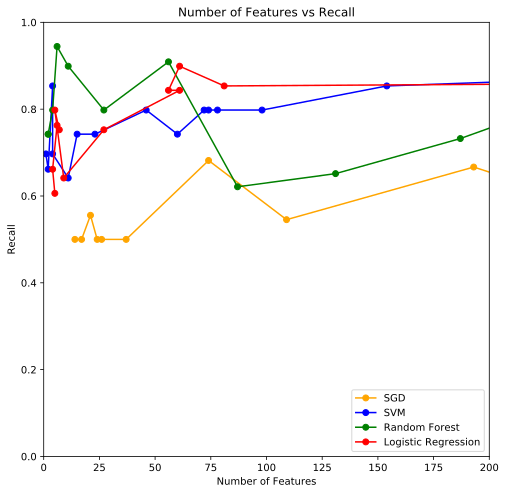

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
figure(num=None, figsize=(8, 8), dpi=800, facecolor='w', edgecolor='k')
plt.xlabel('Number of Features')
plt.ylabel('Recall')
plt.title("Number of Features vs Recall")
plt.plot(n_features_sgd, recall_sgd, 'o-', color='orange')
plt.plot(n_features_svm, recall_svm, 'o-', color='blue')
plt.plot(n_features_rf, recall_rf, 'o-', color='green')
plt.plot(n_features_logit, recall_logit, 'o-', color='red')
plt.legend(['SGD', 'SVM', 'Random Forest', 'Logistic Regression', 'Neural Network'], loc=4)
plt.axis([0, 200, 0, 1])
plt.show()

Random forest provides the best performance for feature selection